In [1]:
%pip install imbalanced-learn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
local_image_dateset = '../datasets/unlabelled_train_data_images.npy'

In [3]:
import warnings
warnings.filterwarnings('ignore')

import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


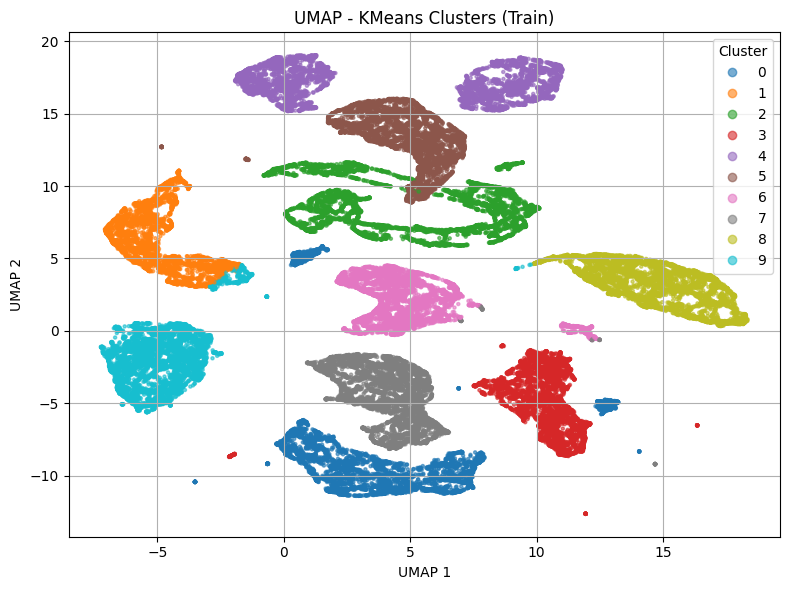

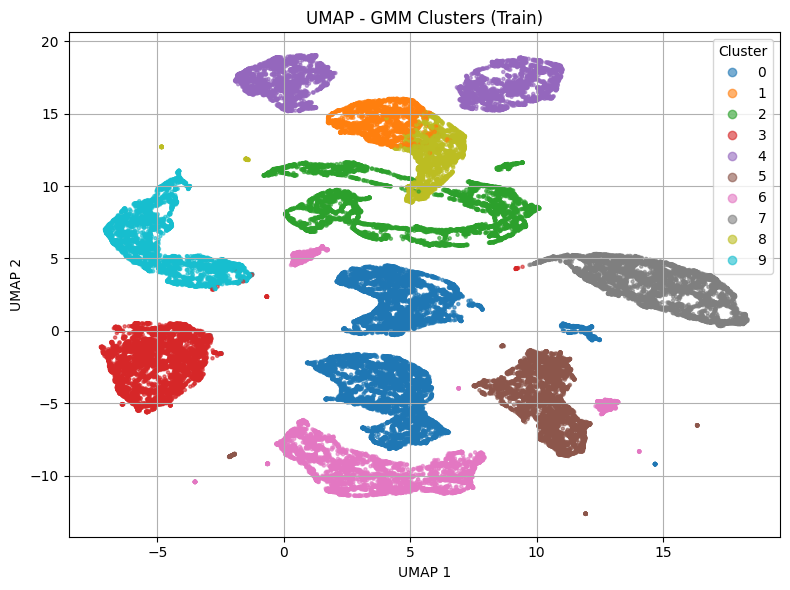

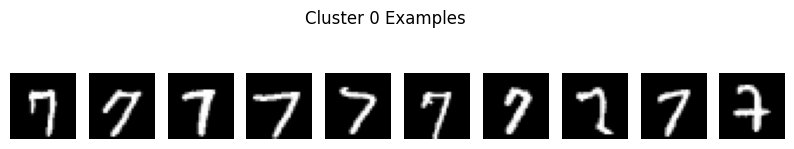

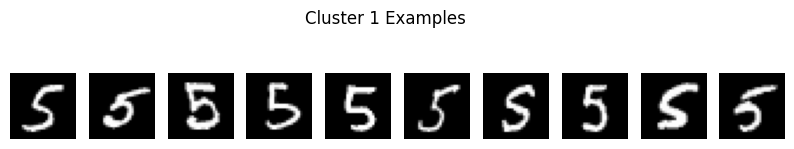

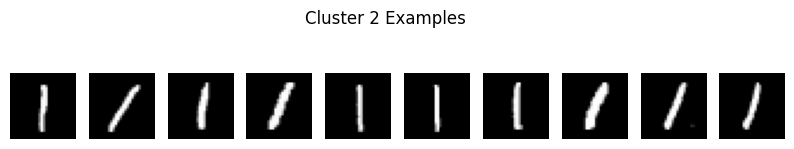

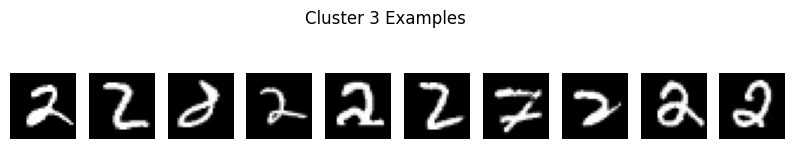

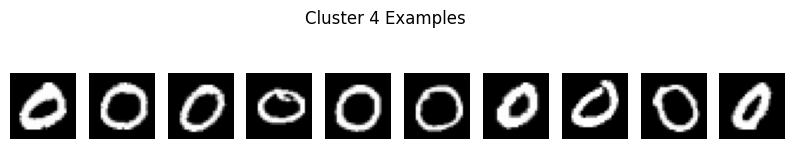

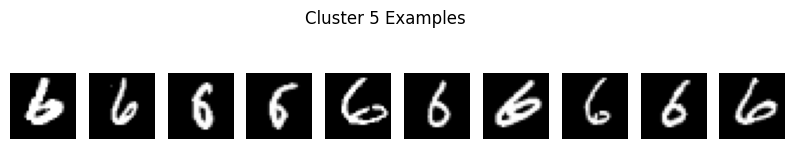

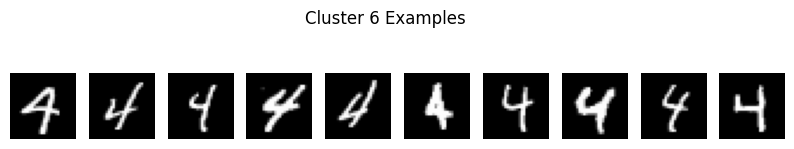

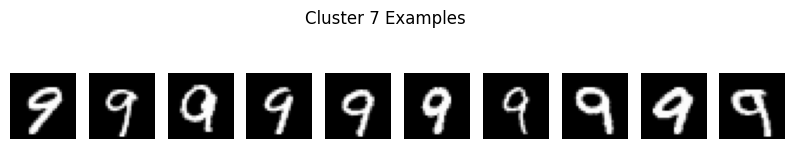

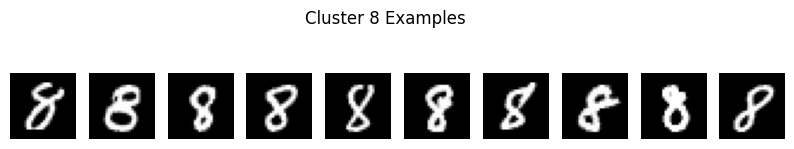

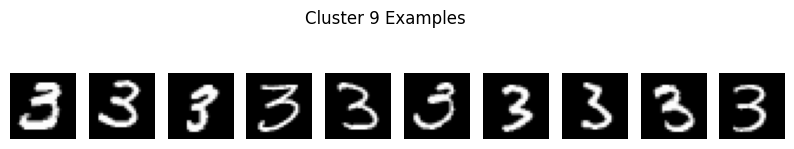

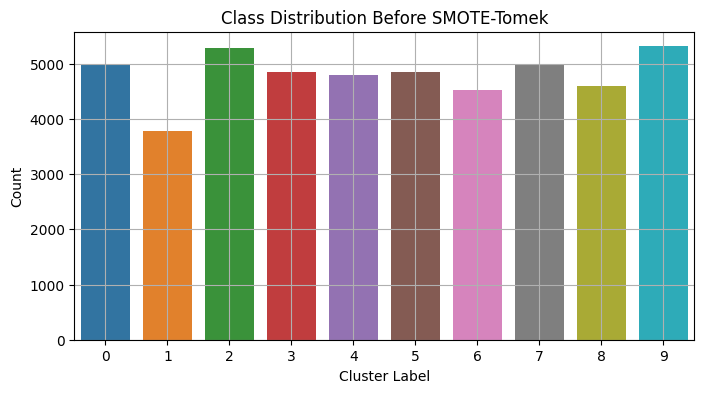

Original shape: (48000, 784) (48000,)
Resampled shape: (53040, 784) (53040,)


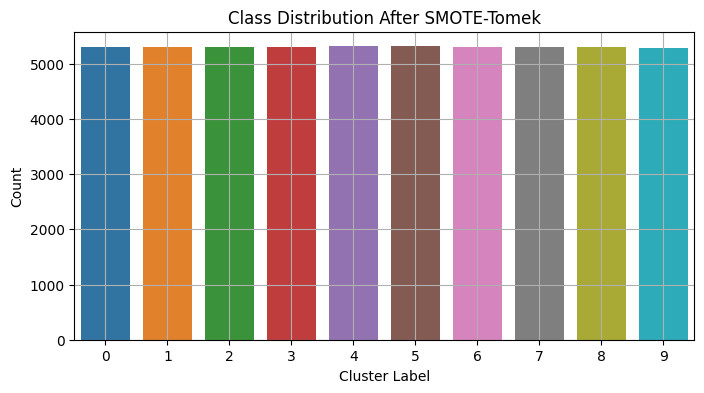

Silhouette Score (train features - UMAP): 0.6930838
Adjusted Rand Score (val - KMeans): 0.9315293228348619
Adjusted Rand Score (val - GMM): 0.8041569189380782
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1289
           1       0.95      0.96      0.95       957
           2       0.99      0.99      0.99      1363
           3       0.94      0.98      0.96      1165
           4       0.99      0.97      0.98      1200
           5       0.99      0.98      0.98      1201
           6       0.97      0.99      0.98      1100
           7       0.97      0.94      0.96      1316
           8       0.95      0.95      0.95      1157
           9       0.94      0.96      0.95      1252

    accuracy                           0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000



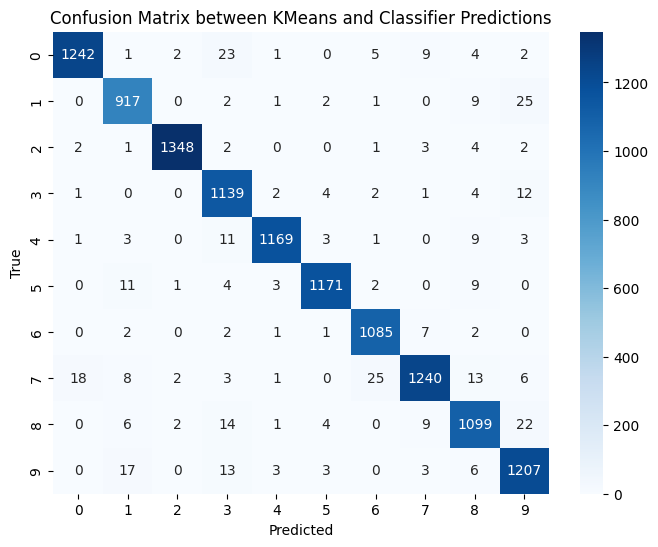

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential, load_model # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization # type: ignore
from tensorflow.keras import Input # type: ignore
from imblearn.combine import SMOTETomek
from umap import UMAP
import seaborn as sns
import joblib
import os

# 1. Load and preprocess dataset
image_dataset = np.load(local_image_dateset)  # (60000, 1, 28, 28)
image_dataset = image_dataset.astype('float32') / 255.0
image_dataset = image_dataset.reshape(-1, 28, 28, 1)  # (60000, 28, 28, 1)

# 2. Train-Validation Split
X_train, X_val = train_test_split(image_dataset, test_size=0.2, random_state=42)

# 3. CNN Feature Extractor using Keras
feature_extractor = Sequential([
    Input(shape=(28, 28, 1)),
    Conv2D(32, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Conv2D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Dropout(0.25),
    Conv2D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Dropout(0.25),
    Flatten()
])

X_train_features = feature_extractor.predict(X_train, verbose=1)
X_val_features = feature_extractor.predict(X_val, verbose=1)

# 4. UMAP Dimensionality Reduction
umap = UMAP(n_components=10, random_state=42)
X_train_umap = umap.fit_transform(X_train_features)
X_val_umap = umap.transform(X_val_features)

# Save UMAP model for reuse
joblib.dump(umap, 'umap_model.pkl')

# UMAP Visualization
def plot_umap_2d(X, labels, title):
    umap_2d = UMAP(n_components=2, random_state=42)
    X_2d = umap_2d.fit_transform(X)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', s=5, alpha=0.6)
    plt.legend(*scatter.legend_elements(), title="Cluster")
    plt.title(title)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 5. Clustering with KMeans and GMM
kmeans = KMeans(n_clusters=10, n_init=20, max_iter=500, random_state=42)
y_train_kmeans = kmeans.fit_predict(X_train_umap)
y_val_kmeans = kmeans.predict(X_val_umap)

gmm = GaussianMixture(n_components=10, covariance_type='full', random_state=42)
y_train_gmm = gmm.fit_predict(X_train_umap)
y_val_gmm = gmm.predict(X_val_umap)

# Visualize clusters
plot_umap_2d(X_train_umap, y_train_kmeans, "UMAP - KMeans Clusters (Train)")
plot_umap_2d(X_train_umap, y_train_gmm, "UMAP - GMM Clusters (Train)")

# 6. Visualize cluster centroids
def show_cluster_examples(X, labels, cluster_id):
    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(np.where(labels == cluster_id)[0][:10]):
        plt.subplot(1, 10, i+1)
        plt.imshow(X[idx].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Cluster {cluster_id} Examples")
    plt.show()

for cid in range(10):
    show_cluster_examples(X_train, y_train_kmeans, cid)

# 7. Assign pseudo-labels using KMeans
X_train_flat = X_train.reshape(len(X_train), -1)
X_val_flat = X_val.reshape(len(X_val), -1)

# Visualize class distribution before SMOTE-Tomek
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train_kmeans, palette='tab10')
plt.title("Class Distribution Before SMOTE-Tomek")
plt.xlabel("Cluster Label")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# 8. Apply SMOTE + TomekLink
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train_flat, y_train_kmeans)

# Verify SMOTETomek is working
print("Original shape:", X_train_flat.shape, y_train_kmeans.shape)
print("Resampled shape:", X_train_resampled.shape, y_train_resampled.shape)

# Visualize class distribution after SMOTE-Tomek
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train_resampled, palette='tab10')
plt.title("Class Distribution After SMOTE-Tomek")
plt.xlabel("Cluster Label")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# 9. Train classifier using pseudo labels
clf = RandomForestClassifier(n_estimators=200, max_depth=25, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# 10. Validate the classifier on validation set
y_val_pred = clf.predict(X_val_flat)

# 11. Evaluation
print("Silhouette Score (train features - UMAP):", silhouette_score(X_train_umap, y_train_kmeans))
print("Adjusted Rand Score (val - KMeans):", adjusted_rand_score(y_val_kmeans, y_val_pred))
print("Adjusted Rand Score (val - GMM):", adjusted_rand_score(y_val_gmm, y_val_pred))

print("Classification Report:")
print(classification_report(y_val_kmeans, y_val_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val_kmeans, y_val_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix between KMeans and Classifier Predictions")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 12. Save feature extractor model
feature_extractor.save("cnn_feature_extractor.keras")

# 13. Reusable Prediction Function
def predict_clusters(
    npy_file_path: str,
    cnn_model_path: str = "cnn_feature_extractor.h5",
    umap_model_path: str = "umap_model.pkl",
    kmeans_model=None,
    gmm_model=None,
    classifier_model=None
):
    if not os.path.exists(npy_file_path):
        raise FileNotFoundError(f"File not found: {npy_file_path}")

    image_array = np.load(npy_file_path)

    if image_array.ndim == 4 and image_array.shape[1] == 1:
        image_array = image_array.reshape(-1, 28, 28, 1)
    elif image_array.ndim == 4 and image_array.shape[3] == 1:
        pass
    else:
        raise ValueError("Input shape must be (n_samples, 1, 28, 28) or (n_samples, 28, 28, 1)")

    images_normalized = image_array.astype('float32') / 255.0

    cnn_model = load_model(cnn_model_path)
    umap_model = joblib.load(umap_model_path)
    features = cnn_model.predict(images_normalized)
    reduced_features = umap_model.transform(features)

    results = {}
    if kmeans_model:
        results['kmeans_labels'] = kmeans_model.predict(reduced_features)
    if gmm_model:
        results['gmm_labels'] = gmm_model.predict(reduced_features)
    if classifier_model:
        images_flat = images_normalized.reshape(len(images_normalized), -1)
        results['classifier_labels'] = classifier_model.predict(images_flat)

    return results


In [ ]:
# Usage for prediction. change the npy file location accordingly
external_test_dataset_npy = 'external_data.npy'
results = predict_clusters(
    npy_file_path=external_test_dataset_npy,
    kmeans_model=kmeans,
    gmm_model=gmm,
    classifier_model=clf
)
print(results['kmeans_labels'][:10])